# test_1

In [129]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
from torch import Tensor
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import random
torch.manual_seed
np.random.seed(50)
random.seed(50)

In [130]:
weights_list = []
weights_sub_list = []
img_path = 'image_test/test62.jpg'      # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [131]:
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]

In [132]:
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map

In [133]:
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [134]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)

In [135]:
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()

In [136]:
max_conv = feature_map[0]

In [137]:
max_conv.shape

torch.Size([1, 512, 7, 7])

In [138]:
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()

In [139]:
score_init

16.673248291015625

In [140]:
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [141]:
from torch import nn
class feature_ablation(nn.Module):
    def __init__(self,i,j):
        super(feature_ablation,self).__init__()
        self.i = i
        self.j = j
    def forward(self,x):
        ones_channel = torch.ones(1, 511, 7, 7)
        zeros_channel = torch.full((1, 1, 7, 7), self.j)
        result_tensor = torch.cat([ones_channel[:, :self.i, :, :], zeros_channel, ones_channel[:, self.i:, :, :]], dim=1)
        ones_channel = torch.full((1, 7, 7), 1)
        x[:, self.i, :, :] = ones_channel
        x = torch.mul(x,result_tensor)
        return x

In [142]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1141.1597672999997


In [143]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)

In [144]:
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)

In [145]:
def _normalize(cams: Tensor) -> Tensor:
    """CAM normalization"""
    cams.sub_(cams.flatten(start_dim=-2).min(-1).values.unsqueeze(-1).unsqueeze(-1))
    cams.div_(cams.flatten(start_dim=-2).max(-1).values.unsqueeze(-1).unsqueeze(-1))
    return cams
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

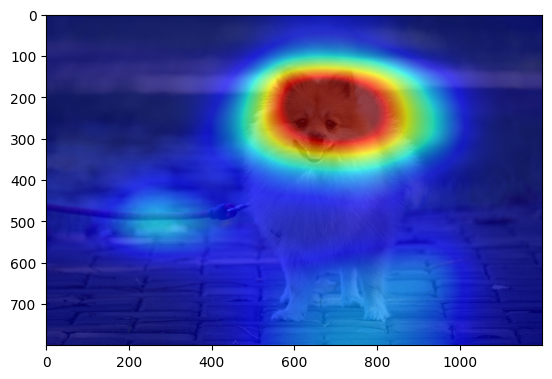

In [146]:
result = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result)
plt.show()

# test_2

In [4]:
weights_list = []
weights_sub_list = []
img_path = 'image_test1/ILSVRC2012_val_00000073.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

D:\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [5]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [6]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1091.3832264


In [7]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

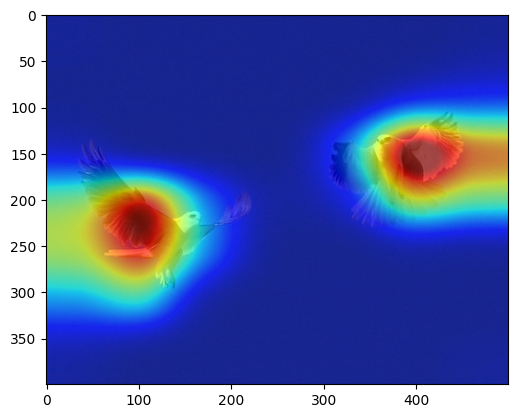

In [8]:
result1 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result1)
plt.show()

# test_3

In [9]:
weights_list = []
weights_sub_list = []
img_path = 'image_test1/ILSVRC2012_val_00000094.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [11]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：938.4010709000001


In [12]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

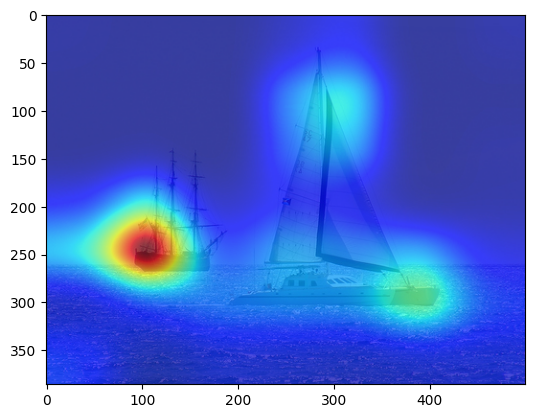

In [13]:
result2 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result2)
plt.show()

# test_4

In [157]:
weights_list = []
weights_sub_list = []
img_path = 'image_test/test_4.jpg'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [158]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [159]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：888.2481957999998


In [160]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

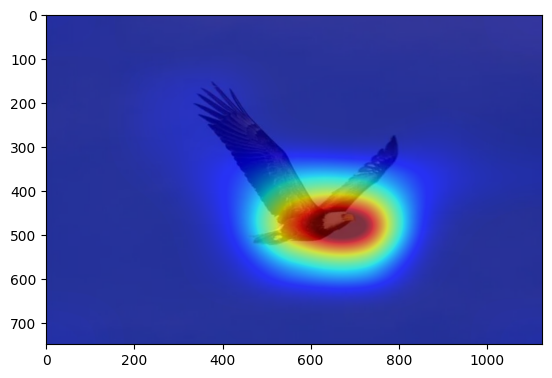

In [161]:
result3 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result3)
plt.show()

# test_5

In [162]:
weights_list = []
weights_sub_list = []
img_path = 'image_test/test_14.jpg'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [163]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [164]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：887.2872778000001


In [165]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

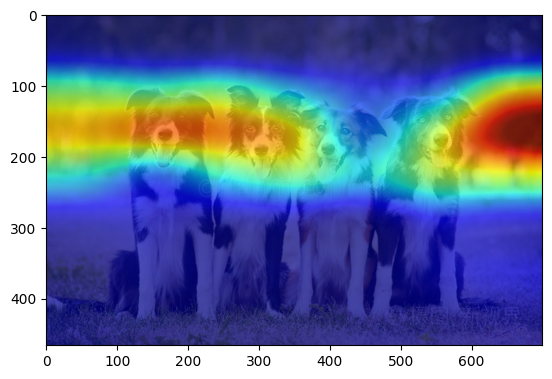

In [166]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

# test6

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
from torch import Tensor
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import random
torch.manual_seed
np.random.seed(50)
random.seed(50)

D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from torch import nn
class feature_ablation(nn.Module):
    def __init__(self,i,j):
        super(feature_ablation,self).__init__()
        self.i = i
        self.j = j
    def forward(self,x):
        ones_channel = torch.ones(1, 511, 7, 7)
        zeros_channel = torch.full((1, 1, 7, 7), self.j)
        result_tensor = torch.cat([ones_channel[:, :self.i, :, :], zeros_channel, ones_channel[:, self.i:, :, :]], dim=1)
        ones_channel = torch.full((1, 7, 7), 1)
        x[:, self.i, :, :] = ones_channel
        x = torch.mul(x,result_tensor)
        return x

In [3]:
def _normalize(cams: Tensor) -> Tensor:
    """CAM normalization"""
    cams.sub_(cams.flatten(start_dim=-2).min(-1).values.unsqueeze(-1).unsqueeze(-1))
    cams.div_(cams.flatten(start_dim=-2).max(-1).values.unsqueeze(-1).unsqueeze(-1))
    return cams

In [7]:
weights_list = []
weights_sub_list = []
img_path = 'image_test/test_5.jpg'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [8]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [9]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1456.5667502


In [10]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

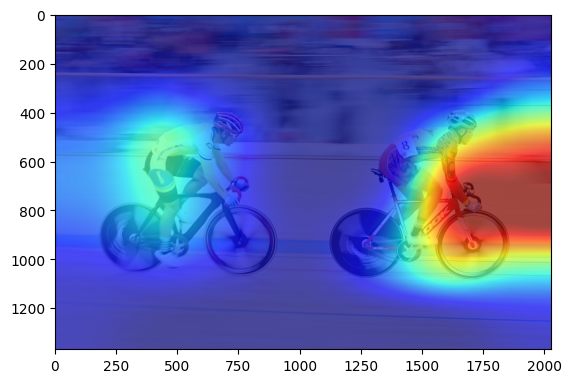

In [11]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

# test7

In [14]:
weights_list = []
weights_sub_list = []
img_path = 'image_test2/ILSVRC2012_val_00000601.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [16]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：727.2563677000003


In [17]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

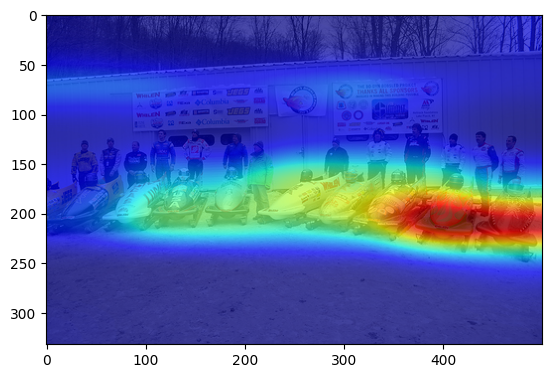

In [18]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

# test8

In [19]:
weights_list = []
weights_sub_list = []
img_path = 'image_test1/ILSVRC2012_val_00000027.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [20]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [21]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1333.3567151000002


In [22]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

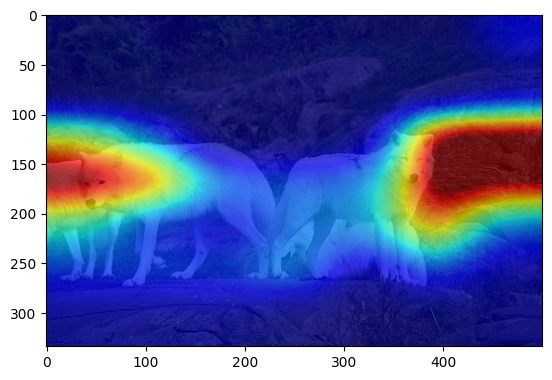

In [23]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

# test9

In [24]:
weights_list = []
weights_sub_list = []
img_path = 'image_test2/ILSVRC2012_val_00000602.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [25]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [26]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1085.4599892000006


In [27]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

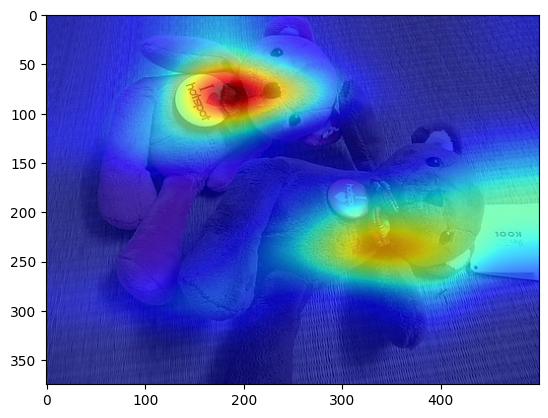

In [28]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

# test_10

In [29]:
weights_list = []
weights_sub_list = []
img_path = 'image_test2/ILSVRC2012_val_00000415.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [30]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [31]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：952.2936196999999


In [32]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

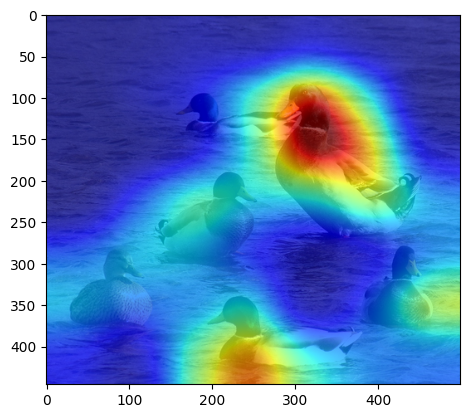

In [33]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

In [9]:
weights_list = []
weights_sub_list = []
img_path = 'image_test1/ILSVRC2012_val_00000003.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [11]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1027.7555139


In [12]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

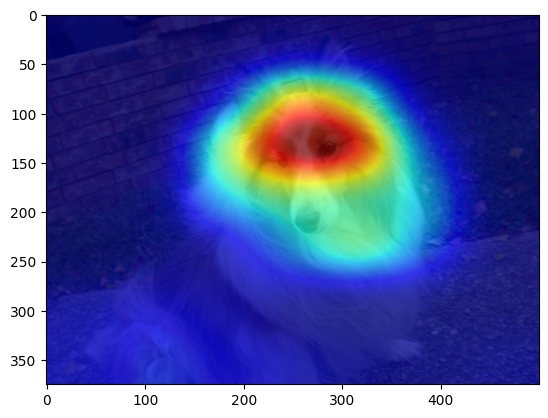

In [13]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

In [14]:
weights_list = []
weights_sub_list = []
img_path = 'image_test1/ILSVRC2012_val_00000009.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [16]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：1148.0584032000002


In [17]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

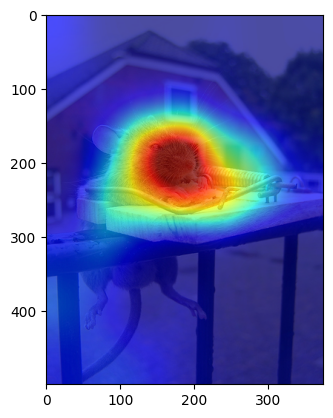

In [18]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()

In [19]:
weights_list = []
weights_sub_list = []
img_path = 'image_test1/ILSVRC2012_val_00000391.JPEG'     # 输入图片的路径
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
orign_img = Image.open(img_path).convert('RGB')    # 打开图片并转换为RGB模型
img = preprocess(orign_img)     # 图片预处理
img = torch.unsqueeze(img, 0)     # 增加batch维度 [1, 3, 224, 224]
feature_map = []
def forward_hook(module, inp, outp):     # 定义hook
    feature_map.append(outp)    # 把输出装入字典feature_map
model = models.vgg16_bn(pretrained=True)
model.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [20]:
hook_handle = model.features.register_forward_hook(forward_hook)
hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
out = model(img) # 前向传播
hook_handle.remove()
hook_handle_1.remove()
max_conv = feature_map[0]
cls_idx = torch.argmax(feature_map[1]).item()# 获取预测类别编码
score = feature_map[1][:, cls_idx] # 获取预测类别分数
score_init = score.item()
max_value = torch.max(max_conv).item()
min_value = torch.min(max_conv).item()

In [21]:
import time
start = time.perf_counter()
for i in range(512):
    for j in range(int(min_value), int(max_value) + 1): 
        model.features.add_module('ablation',feature_ablation(i,j))
        feature_map = []
        hook_handle = model.features.register_forward_hook(forward_hook)
        hook_handle_1 = model.classifier.register_forward_hook(forward_hook)
        out = model(img) # 前向传播
        hook_handle.remove()
        hook_handle_1.remove()
        score = feature_map[1][:, cls_idx] # 获取预测类别分数
        score = score.item()
        weight_score = (score_init - score)/score_init
        weights_sub_list.append(weight_score)
        del model.features[44]
    max_weight = max(abs(weight) for weight in weights_sub_list)
    original_max_value = max(weight for weight in weights_sub_list if abs(weight) == max_weight)
    if original_max_value < 0:
        max_value_with_sign = -original_max_value
    else:
        max_value_with_sign = original_max_value
    weights_list.append(max_value_with_sign)
    weights_sub_list = []
end = time.perf_counter()
print(f'运行时间：{end-start}')

运行时间：810.7943124999997


In [22]:
weights_list = torch.tensor(weights_list)  # 将列表转换为PyTorch张量
weights_tensor = weights_list.view(512, 1, 1)
grad_cam = (weights_tensor * max_conv.squeeze(0)).sum(0)
grad_cam = _normalize(F.relu(grad_cam, inplace=True))
mask = to_pil_image(grad_cam.detach().numpy(), mode='F')

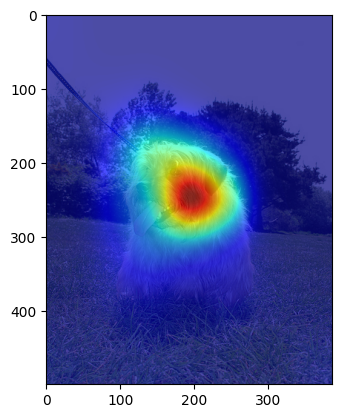

In [23]:
result4 = overlay_mask(orign_img, mask,alpha = 0.3)
plt.imshow(result4)
plt.show()